## Subject 2: Text NewsGroup Classification
###### <p style="float:right">Gînga Raluca-Andreea</p>


1. Download the newsgroups data set using the code below. 
2. Construct a text classifier that predicts the target variable (newsgroups.target) from the input data (newsgroups.data).
3. We will evaluate your classifier against a hold-out data set, so be sure to construct a classification function that can receive a single string.

#### Importing the required libraries

In [54]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.neural_network.multilayer_perceptron import MLPClassifier
from time import time
import string
import re
import nltk
from nltk import word_tokenize

#### Loading the dataset

In [55]:
newsgroups = fetch_20newsgroups(subset='train')
X, y = newsgroups.data, newsgroups.target

#### Data Exploration

In [56]:
X[:4]

["From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n",
 "From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washington\nLines: 

In [57]:
print(X[0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [58]:
print('Number of articles: {}'.format(len(X)))
print('Number of news categories: {}'.format(len(y)))

Number of articles: 11314
Number of news categories: 11314


(-1.1001974195392712,
 1.1005581358450969,
 -1.1014211451217777,
 1.1000676735772275)

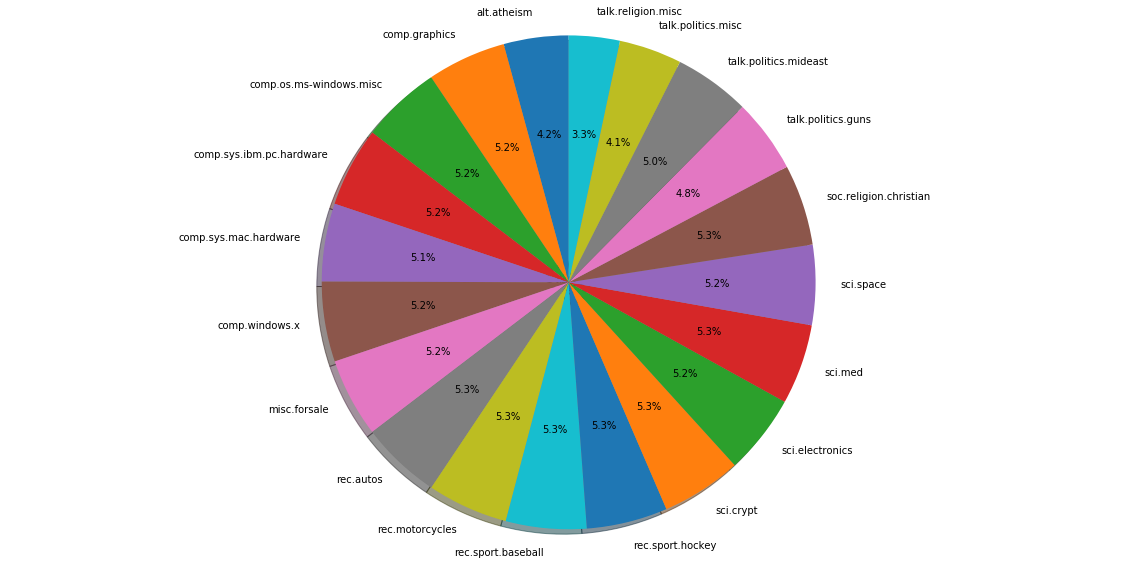

In [59]:
# Creating a list with the target names
labels = []
for i in newsgroups.target_names:
    labels.append(i)
    
labels

# Counting the number of news per category
sizes = np.bincount(y)

fig1, ax1 = plt.subplots(figsize=(20,10))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    

## Data Preprocessing

After importing our data, we can start processing our data. Since we are working with texts, we need to make them understandable for the computer and for our classification algorithms. Thus, we need to transform textual data into numbers, or better a numerical matrix. For that, we will use a range of natural language processing techniques.

To perform some natural language processing tasks, we will use the NLTK library, Natural Language Toolkit.

### <li> Stop Words </li>

This library will help us to perform tasks such as removing stop words (or empty words), which can be considered irrelevant to the context of speech and writing. We can say that these words are the most common of the language or functional words (function words, such as “the”, “a”, “an”, “in”), however, there is no universal list of stop words, and these vary from context to context. For our context, the list available in the NLTK library will be sufficient for the initial processing. 

### <li> Text Tokenization </li>

It is also necessary to transform our text into 'tokens', which is our document broken into words. Token is a piece of the whole, so a word is a token in a sentence, and a sentence is a token in a paragraph. For our problem we will transform our document (document being a set of phrases or paragraphs) into words, forming a vector.

### <li> Stemming </li>

Stemming is the process of getting to the root of a word, via cuts. Therefore, with the use of basic rules, any token can be polished to its root, thus, stemming is a rules-based process in which we want to combine all different variations of the token. A stemming algorithm reduces, for example, the words “chocolates”, “chocolatey”, “choco” to the root word, “chocolate” and “loves”, “loved”, “loving” reduce to the stem “lov”.

### <li>Lemmatization</li>

Lemmatization is a methodical way of converting any grammatical or inflated form from a term to its root. Lemmatization uses context and part of speech to determine the inflated form of a word and applies different normalization rules to each part of speech to achieve the root form of the term (lemma). Lemmatization is similar to stemming but it brings context to the words. So it links words with similar meaning to one word.

In [60]:
def text_preprocessing(text, lemmatize):
    if not isinstance(text, str):
        text = text.decode('ISO-8859-1')
    
    text = re.sub('[^a-zA-Z]', ' ', text) # Clear the special characters from our dataset
    text = text.lower() 
    text = text.split() 
    text = ' '.join(text)
    #print('\tClear Text.\n', text)

    # Tokenize
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    #print('\tTokenizing.\n', tokens)

    # Removing the stopwords
    stop = stopwords.words('english')
    tokens = [token for token in tokens if token not in set(stop)]
    #print('\tRemoving the stopwords.\n', tokens)
    
    # Remove words shorter than 3 characters
    tokens = [token for token in tokens if len(token) >= 2]
    #print('\tRemoving the words shorter than 3 characters\n', tokens)
    

    if lemmatize:
        # Lemmatize
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        #print('\tLemmatizing.\n', tokens)
    else:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(word) for word in tokens]
    
    # Preprocessed text
    tokens = ' '.join(tokens)
    
    return tokens

In [61]:
t0 = time()
X = [text_preprocessing(doc, True) for doc in X]
print('Cleaning time: %0.3fs' % (time() - t0))

Cleaning time: 62.901s


In [62]:
X[:3]

['lerxst wam umd edu thing subject car nntp posting host rac wam umd edu organization university maryland college park line wondering anyone could enlighten car saw day door sport car looked late early called bricklin door really small addition front bumper separate rest body know anyone tellme model name engine spec year production car made history whatever info funky looking car please mail thanks il brought neighborhood lerxst',
 'guykuo carson washington edu guy kuo subject si clock poll final call summary final call si clock report keywords si acceleration clock upgrade article shelley qvfo innc organization university washington line nntp posting host carson washington edu fair number brave soul upgraded si clock oscillator shared experience poll please send brief message detailing experience procedure top speed attained cpu rated speed add card adapter heat sink hour usage per day floppy disk functionality floppy especially requested summarizing next two day please add network k

## Feature Extraction

Now that we have our data clean, we can turn it into a numeric representation, or better, a matrix.

### <li>Bag of Words</li>

The most common way to achieve this goal is through Bag of Words that "learns" a vocabulary from our set of data, then models each document from the count of the occurrence of each word. In this way we discard most of the structure of a text, such as paragraphs, sentences and formatting, just counting how frequent a word is in each document. So, this technique took the image of a bag or a handful of words. This technique is implemented by the CountVectorizer function.

In [63]:
vectorizer_bow = CountVectorizer(max_features=100000) 
X_bow = vectorizer_bow.fit_transform(X)

### <li>TF-IDF (Term Frequency - Inverse Document Frequency)</li>

TF-IDF is a good statistical measure that reflects the relevance of a term to the document. This method calculates a weight for each term based on how often it appears in a document. Therefore, if a word appears very often in a specific document, but not in several documents, it is likely that that term is important for that document's context.

In [64]:
vectorizer_tfidf = TfidfVectorizer(min_df=1,
                                   max_df=0.7, # Removing frequent words like 'subject' that appear in every news
                                   ngram_range=(1,2), 
                                   lowercase=False, # we've already lowercased the text
                                   stop_words='english', 
                                   max_features=1340000)
X_tfidf = vectorizer_tfidf.fit_transform(X)

## Building ML models

### <li>Train/Test Splitting</li>

In [81]:
X_train_bw, X_test_bw, y_train_bw, y_test_bw = train_test_split(X_bow, y, test_size=0.20)
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tfidf, y, test_size=0.20)

### Multinomial Naive Bayes

In [82]:
nb = MultinomialNB()

### Stochastic Gradient Descent

In [83]:
sgd = SGDClassifier(alpha=.0001, max_iter=50, penalty="l2", tol=1e-3)

### Support Vector Machines

In [85]:
svm = LinearSVC(penalty='l2', dual=True, tol=1e-3)


### Passive Aggressive Classifier

In [90]:
pac = PassiveAggressiveClassifier(max_iter=50, tol=1e-3)

### <li>Choice of Classifier</li>

Next, we will define a **cross-validation** function that we will use later, testing several algorithms.

In [91]:
def cross_validation(classifier, X, y):
    scores = cross_val_score(classifier, X, y, cv = 5, scoring = 'accuracy')
    return scores.mean()

In [92]:
classifiers = {
    'Multinomial Naive Bayes': nb,
    'Stochastic Gradient Descent': sgd,
    'Support Vector Machines': svm,
    'Passive Agressive': pac
}
X_s = {
    'BagOfWords': X_bow, 
    'TF-IDF': X_tfidf
}

for X1 in X_s:
    print(X1)
    for clf in classifiers:
        scores = cross_validation(classifiers[clf], X_s[X1], y)
        print ('\t {} - {}'.format(clf, scores))

BagOfWords
	 Multinomial Naive Bayes - 0.8612355890428957


C:\Users\Raluca\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Raluca\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Raluca\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Raluca\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


	 Stochastic Gradient Descent - 0.8364924027806129


C:\Users\Raluca\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Raluca\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Raluca\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Raluca\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Raluca\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iteration

	 Support Vector Machines - 0.8822801698888598
	 Passive Agressive - 0.888204273676163
TF-IDF
	 Multinomial Naive Bayes - 0.8796114566731328
	 Stochastic Gradient Descent - 0.926909482127112
	 Support Vector Machines - 0.9266444617723966
	 Passive Agressive - 0.9262911805687424


### Hyperparameter Tuning

After executing these algorithms with those 2 different feature extraction techniques, we came to the conclusion that the Linear SVM algorithm using TFIDF achieved the best results and could be a good candidate to predict the correct answers with greater accuracy. Therefore, we chose this approach for the optimization of hyper-parameters. The best way to choose a good hyper-parameter is by trial and error of all possible combinations of values for such parameters. 

In Scikit-learn library, we can find the GridSeachCV function and RandomSearchCV that facilitate this trial and error. Using GridSearch for a given model, we can define a set of parameters and values that we want to test, so the GridSearchCV function in the Scikit-learn library creates models for all possible combinations within the pre-defined list of hyper-parameter values. At the end of the creation of all models, the best combination is chosen through the cross-validation evaluation technique. 

In [93]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC()),
])

parameters = {
    'tfidf__max_features': (None, 1340000),
    'tfidf__lowercase': (False, ),
    'tfidf__max_df': (0.6, 0.7, 0.8),
    'tfidf__ngram_range': ((1, 1), (1, 2)),
    'tfidf__stop_words': (None, 'english'),
    'tfidf__norm': ('l2', ),
    'clf__penalty': ('l2', ),
    'clf__tol': (1e-2, 1e-3, 1e-5),
    'clf__C': (0.5, 0.7, 0.9),
    'clf__max_iter': (100, 1000, 2000)
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
t0 = time()
grid_search.fit(X, y)
print("done in %0.3fs\n" % (time() - t0))

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

C:\Users\Raluca\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 648 candidates, totalling 1944 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 22.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 38.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 60.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 89.3min
[Parallel(n_jobs=-1)]: Done 1944 out of 1944 | elapsed: 98.1min finished


done in 5895.816s

Best score: 0.920
Best parameters set:
	clf__C: 0.9
	clf__max_iter: 100
	clf__penalty: 'l2'
	clf__tol: 0.01
	tfidf__lowercase: False
	tfidf__max_df: 0.6
	tfidf__max_features: 1340000
	tfidf__ngram_range: (1, 2)
	tfidf__norm: 'l2'
	tfidf__stop_words: 'english'


In [114]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, recall_score

vect_tfidf1 = TfidfVectorizer(max_df=0.6, 
                                   ngram_range=(1,2), 
                                   norm='l2',
                                   lowercase=False, 
                                   stop_words='english', 
                                   max_features=1340000 
                                  )
t0 = time()
scoring = {'prec_macro': 'precision_macro',
           'rec_micro': make_scorer(recall_score, average='macro')}
X_tfidf1 = vect_tfidf1.fit_transform(X)
print('TF-IDF time: %0.3fs' % (time() - t0))
svm1 = LinearSVC(penalty='l2', dual=True, tol=0.01, C=0.9, max_iter=100)

score = cross_validate(svm1, X_tfidf1, y, scoring=scoring,
                                cv=10, return_train_score=True)
print ('\t SVMLinear with hyperparameter tuning - {}'.format(np.mean(score['test_prec_macro'])))



TF-IDF time: 7.228s
	 SVMLinear with hyperparameter tuning - 0.9328379249246069


Accuracy on Train: 0.9996685449121644
Accuracy on Test: 0.926646045072912


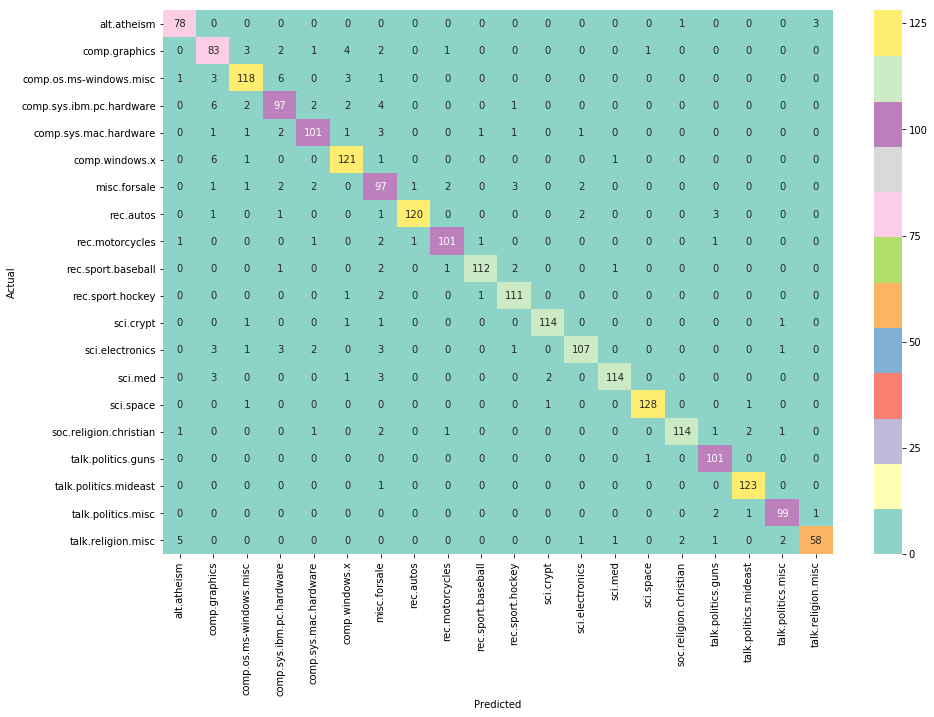

In [137]:
classifier = Pipeline([('vectorizer', vect_tfidf1),('classifier', svm1)])

X_train, X_test, y_train, y_test = train_test_split(newsgroups.data, newsgroups.target, test_size=0.2, random_state=11)
classifier.fit(X_train, y_train)

print("Accuracy on Train: " + str(classifier.score(X_train, y_train)))
print("Accuracy on Test: " + str(classifier.score(X_test, y_test)))

y_pred = classifier.predict(X_test)

# Plot confusion_matrix
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap = "Set3", fmt ="d",
xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [123]:
print(classification_report(y_test, y_pred, target_names=labels))

                          precision    recall  f1-score   support

             alt.atheism       0.91      0.95      0.93        82
           comp.graphics       0.78      0.86      0.81        97
 comp.os.ms-windows.misc       0.91      0.89      0.90       132
comp.sys.ibm.pc.hardware       0.85      0.85      0.85       114
   comp.sys.mac.hardware       0.92      0.90      0.91       112
          comp.windows.x       0.90      0.93      0.92       130
            misc.forsale       0.78      0.87      0.82       111
               rec.autos       0.98      0.94      0.96       128
         rec.motorcycles       0.95      0.94      0.94       108
      rec.sport.baseball       0.97      0.94      0.96       119
        rec.sport.hockey       0.93      0.97      0.95       115
               sci.crypt       0.97      0.97      0.97       118
         sci.electronics       0.95      0.88      0.91       121
                 sci.med       0.97      0.93      0.95       123
         

## Required function

In [105]:
def predict_category(s, train = newsgroups):
    pred = classifier.predict([s])
    return newsgroups.target_names[pred[0]]

#### Testing the function

In [135]:
# Creating a list of strings

s = ['discussing islam vs atheism', 'chevrolet is releasing a new car', 'a new form of diabetes', 
     'Elon Musk, is planning to put more than 4,000 satellites in orbit', 'mac is cool', 'easter is coming',
     'Young hockey player gets NHL to change their playing cards', 'Donald Trump vs Iran',
    'Michael Jordan loves This Baseball Player', 'MLB ineligible list ends at death for banned players',
     'new Samsung TV released', 'Xiaomi released a new fitness band']

# Iterating through the list and printing the predicted categories

for string in s:
    print(predict_category(string))

alt.atheism
rec.autos
sci.med
sci.space
comp.sys.mac.hardware
soc.religion.christian
rec.sport.hockey
talk.politics.mideast
rec.sport.baseball
rec.sport.baseball
sci.electronics
misc.forsale
